# Testing with some Deep Learning Model

Following https://github.com/Yura52/rtdl/blob/main/examples/rtdl.ipynb

In [1]:
import sys; sys.path.append("../../")

import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timezone, timedelta
from typing import Any, Dict

import numpy as np
import scipy.special
import sklearn.datasets
import sklearn.metrics
import sklearn.model_selection
import sklearn.preprocessing
import sklearn
from sklearn.utils.class_weight import compute_class_weight
import torch
import torch.nn as nn
import torch.nn.functional as F
import zero
from sklearn.metrics import f1_score
from modules.utils import load_yaml, save_yaml
from modules.evaluation import pretty_classification_report, plot_confusion_matrix
from models.ft_transformer.modules import FTTransformer, MLP, ResNet

## Load model



In [1]:
# Model loading
PREDICT_TIMESTAMP = '20220609013328'
device = torch.device('cuda:0')

def load_model(folder, name='best.pt'):
    SAVE_DIR = f'checkpoints/{folder}'
    model_dict = torch.load(os.path.join(SAVE_DIR, name))
    model_config = load_yaml(os.path.join(SAVE_DIR, 'model_config.yaml'))
    model = FTTransformer.make_default(**model_config)
    model.load_state_dict(model_dict)
    return model.eval()


model = load_model(PREDICT_TIMESTAMP)
model.to(device)

NameError: name 'torch' is not defined

In [5]:
train_df = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
valid_df = pd.read_csv(os.path.join(DATA_PATH, 'valid.csv'))


print(len(train_df))

26880


In [15]:
print(len(train_df))
print(len(valid_df))

train_df = pd.concat([train_df, valid_df], ignore_index=True)
print(len(train_df))


26880
6720
33600


In [14]:
# Setups
TRAIN_CONFIG_PATH = '../../config/train_config.yaml'
DATA_PATH = '../../data/01_split/'
config = load_yaml(TRAIN_CONFIG_PATH)
LABEL_ENCODING = config['LABEL_ENCODING']
LABEL_DECODING = {y:x for x,y in LABEL_ENCODING.items()}
# RESULTS_PATH = '.'
RESULTS_PATH = f'checkpoints/{PREDICT_TIMESTAMP}'
DATA_DIR = '../../data/01_split'
SAMPLE_DIR = '../../data/sample_submission.csv'


# Data loading
train_df = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
valid_df = pd.read_csv(os.path.join(DATA_PATH, 'valid.csv'))
test_df = pd.read_csv(os.path.join(DATA_PATH,'test.csv'))
test_ids = test_df['id']


X = {}
y = {}
train_X, train_y = train_df.loc[:,train_df.columns!='leaktype'], train_df['leaktype']
valid_X, valid_y = valid_df.loc[:,train_df.columns!='leaktype'], valid_df['leaktype']
test_X = test_df.loc[:,test_df.columns!='id']


train_y = train_y.replace(LABEL_ENCODING)
valid_y = valid_y.replace(LABEL_ENCODING)

X['train'],  X['val'], X['test'] = train_X, valid_X, test_X
y['train'], y['val'] = train_y, valid_y

# not the best way to preprocess features, but enough for the demonstration
preprocess = sklearn.preprocessing.StandardScaler().fit(X['train'])
X = {
    k: torch.tensor(preprocess.transform(v), device=device)
    for k, v in X.items()
}
X = {k: v.float() for k, v in X.items()}


../../config/train_config.yaml


In [44]:
def get_predictions(model, test_X, batch_size_eval=32):
    """Get predictions from FTTransformer model"""
    with torch.no_grad():
        model.eval()
        prediction = []
        for batch in zero.iter_batches(test_X, batch_size_eval):
            prediction.append(model(batch.float(), x_cat=None).cpu())
        pred_y = torch.cat(prediction).squeeze(1).cpu().numpy()
        pred_y = pred_y.argmax(1)
    return pred_y

## Quick testing

F1 score : 0.869


,precision,recall,f1-score,support
0,0.946290,0.890293,0.917437,1504
1,0.911968,0.898635,0.905253,1026
2,0.973728,0.986410,0.980028,3532
3,0.718157,0.815385,0.763689,325
4,0.760807,0.792793,0.776471,333
accuracy,0.933631,0.933631,0.933631,0
macro avg,0.862190,0.876703,0.868576,6720
weighted avg,0.935247,0.933631,0.934053,6720


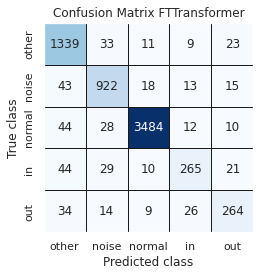

In [45]:
encoding_to_label = {v: k for k, v in LABEL_ENCODING.items()}
labels = [key for key in LABEL_ENCODING.keys()]
model_name, y_hat = 'FTTransformer', get_predictions(model, X['val'])

plot_confusion_matrix(valid_y, y_hat, labels,  f'Confusion Matrix {model_name}')
print('F1 score : {:.3f}'.format(f1_score(valid_y, y_hat, average='macro')))
pretty_classification_report(valid_y, y_hat)

## Submission

In [48]:
def model_predict_submission(model, X_test):
    # Make predictions
    sample_df = pd.read_csv(SAMPLE_DIR)
    sorter = list(sample_df['id'])
    y_pred = get_predictions(model, X_test)
    y_pred_df = pd.DataFrame(y_pred, columns=['leaktype'])
    y_pred_df['leaktype'] = y_pred_df['leaktype'].replace(LABEL_DECODING)
    pred_df = pd.concat([test_ids, y_pred_df],axis=1)
    # sort predictions
    resdf = pred_df.set_index('id')
    result = resdf.loc[sorter].reset_index()
    resultpath = os.path.join(RESULTS_PATH, 'predictions.csv')
    result.to_csv(resultpath, index=False)

In [49]:
# Make predictions and save results
model_predict_submission(model, X['test'])